In [1]:
from sage.all import *
import numpy as np
import random
import hashlib
import time
import matplotlib.pyplot as plt

In [40]:
from sage.all import *
from random import shuffle
import hashlib

class BikeKEM:
    """
    BIKE KEM Implementation (Best-of-Both Merge)
    Based on BIKE Spec v5.2: https://bikesuite.org/files/v5.2/BIKE_Spec.2024.10.10.1.pdf
    
    Features:
    - Matrix-based circulant representation (reliable decoder)
    - Parameter validation per spec
    - Hash-based shared secret K = H(e0, e1, c)
    - Working bit-flipping decoder for toy parameters
    """

    def __init__(self, r=53, w=6, t=4):
        """
        Initialize BIKE parameters.
        
        r : prime, defines ring R = F2[x]/(x^r - 1)
        w : row weight of H (must be even, w/2 odd per spec)
        t : total error weight
        """
        # Parameter validation per BIKE spec
        assert is_prime(r), f"r={r} must be prime"
        assert w % 2 == 0, "w must be even"
        assert (w // 2) % 2 == 1, "w/2 must be odd"
        
        self.r = r
        self.w = w
        self.t = t
        self.d = w // 2  # Column weight
        
        # Field setup
        self.F2 = GF(2)

    # ------------------------------------------------------------------
    # Matrix Utilities (Circulant representation)
    # ------------------------------------------------------------------

    def _vector_to_circulant(self, vec):
        """
        Create circulant matrix from first row vector.
        Row i is row 0 rotated right by i positions.
        """
        n = len(vec)
        rows = []
        for i in range(n):
            # Rotate right by i: last i elements move to front
            rotated = list(vec[-i:]) + list(vec[:-i]) if i > 0 else list(vec)
            rows.append(rotated)
        return matrix(self.F2, rows)

    def _random_sparse_vector(self, weight):
        """Generate random binary vector of given Hamming weight."""
        indices = list(range(self.r))
        shuffle(indices)
        vec = [0] * self.r
        for i in range(weight):
            vec[indices[i]] = 1
        return vector(self.F2, vec)

    def _weight(self, vec):
        """Hamming weight of a vector."""
        return sum(int(x) for x in vec)

    def _hash_function(self, *args):
        """Hash function H using SHA-256 per spec."""
        data = b''
        for arg in args:
            if hasattr(arg, '__iter__') and not isinstance(arg, (str, bytes)):
                data += bytes([int(x) for x in arg])
            else:
                data += bytes(str(arg), 'utf-8')
        return hashlib.sha256(data).digest()

    # ------------------------------------------------------------------
    # Key Generation (Spec Section 2.2.1)
    # ------------------------------------------------------------------

    def key_gen(self):
        """
        Generate BIKE key pair.
        
        Private key: (h0, h1) as sparse vectors with wt = d
        Public key: H0^(-1) * H1 as circulant (stored as first row)
        
        Returns: (sk, pk) where sk = (h0, h1, H0_inv), pk = h (first row of H)
        """
        # Generate h0 with weight d, ensure H0 is invertible
        while True:
            h0 = self._random_sparse_vector(self.d)
            H0 = self._vector_to_circulant(h0)
            if H0.is_invertible():
                break
        
        # Generate h1 with weight d
        h1 = self._random_sparse_vector(self.d)
        H1 = self._vector_to_circulant(h1)
        
        # Public key: H = H0^(-1) * H1
        H0_inv = H0.inverse()
        H_pub = H0_inv * H1
        
        # Store first row as public key (circulant is determined by first row)
        pk = vector(self.F2, H_pub.row(0))
        
        # Private key includes H0_inv for decapsulation
        sk = (h0, h1, H0_inv)
        
        return sk, pk

    # ------------------------------------------------------------------
    # Encapsulation (Spec Section 2.2.2)
    # ------------------------------------------------------------------

    def encaps(self, pk):
        """
        Encapsulate: Generate ciphertext and shared secret.
        
        1. Sample error e = (e0, e1) with wt(e0) + wt(e1) = t
        2. Compute c = e0 + H * e1
        3. K = H(e0, e1, c)
        
        Returns: (c, (K, (e0, e1)))
        """
        # Split error weight
        t0 = self.t // 2
        t1 = self.t - t0
        
        e0 = self._random_sparse_vector(t0)
        e1 = self._random_sparse_vector(t1)
        
        # Compute c = e0 + H * e1
        H = self._vector_to_circulant(pk)
        c = e0 + H * e1
        
        # Shared secret K = H(e0 || e1 || c)
        K = self._hash_function(e0, e1, c)
        
        return c, (K, (e0, e1))

    # ------------------------------------------------------------------
    # Decapsulation (Spec Section 2.2.3)
    # ------------------------------------------------------------------

    def decaps(self, sk, c):
        """
        Decapsulate: Recover shared secret from ciphertext.
        
        1. Compute syndrome s = H0 * c = e0*h0 + e1*h1
        2. Decode to find (e0, e1)
        3. K = H(e0, e1, c)
        
        Returns: (K, (e0, e1)) or None on failure
        """
        h0, h1, H0_inv = sk
        
        # Compute syndrome
        H0 = self._vector_to_circulant(h0)
        H1 = self._vector_to_circulant(h1)
        syndrome = H0 * c  # = H0*e0 + H0*H0^(-1)*H1*e1 = H0*e0 + H1*e1
        
        # Decode using bit-flipping
        e0, e1 = self._bit_flipping_decoder(syndrome, H0, H1)
        
        if e0 is None:
            return None
        
        # Verify weight constraint
        if self._weight(e0) + self._weight(e1) != self.t:
            return None
        
        # Verify syndrome
        if H0 * e0 + H1 * e1 != syndrome:
            return None
        
        # Compute shared secret
        K = self._hash_function(e0, e1, c)
        
        return (K, (e0, e1))

    # ------------------------------------------------------------------
    # Bit-Flipping Decoder (BGF-style)
    # ------------------------------------------------------------------

    def _bit_flipping_decoder(self, syndrome, H0, H1, max_iter=50):
        """
        Matrix-based bit-flipping decoder.
        
        Uses explicit matrix operations for reliable UPC computation.
        The parity-check matrix is H = [H0 | H1] (r x 2r).
        """
        # Initialize error estimate
        e0 = vector(self.F2, [0] * self.r)
        e1 = vector(self.F2, [0] * self.r)
        
        # Current syndrome
        s = syndrome
        
        for iteration in range(max_iter):
            # Check if done
            if s.is_zero():
                return e0, e1
            
            # Compute UPC (Unsatisfied Parity Checks) for each bit
            # UPC[i] = number of unsatisfied checks that bit i participates in
            
            upc0 = []
            for i in range(self.r):
                # Column i of H0 tells which checks bit i of e0 participates in
                col = H0.column(i)
                # Count how many of these checks are unsatisfied (s[j] = 1)
                count = sum(int(col[j]) * int(s[j]) for j in range(self.r))
                upc0.append(count)
            
            upc1 = []
            for i in range(self.r):
                col = H1.column(i)
                count = sum(int(col[j]) * int(s[j]) for j in range(self.r))
                upc1.append(count)
            
            # Find threshold (max UPC)
            max_upc = max(max(upc0), max(upc1))
            
            if max_upc == 0:
                # No bits to flip, but syndrome nonzero = failure
                break
            
            # Adaptive threshold: start aggressive, become conservative
            # This helps convergence for MDPC codes
            threshold = max(max_upc - iteration // 10, (self.d + 1) // 2)
            threshold = max(threshold, max_upc)  # Don't go below max for first iters
            
            # Flip bits with UPC >= threshold
            flipped = False
            for i in range(self.r):
                if upc0[i] >= threshold:
                    e0[i] += 1  # Flip (mod 2)
                    flipped = True
            for i in range(self.r):
                if upc1[i] >= threshold:
                    e1[i] += 1
                    flipped = True
            
            if not flipped:
                break
            
            # Update syndrome
            s = syndrome - (H0 * e0 + H1 * e1)
        
        # Check final result
        if s.is_zero():
            return e0, e1
        
        return None, None


# ----------------------------------------------------------------------
# Test Harness
# ----------------------------------------------------------------------

def check_exercise():
    print("=" * 60)
    print("BIKE KEM - Merged Best-of-Both Implementation")
    print("Based on BIKE Spec v5.2")
    print("=" * 60)

    # Parameters that work reliably with bit-flipping
    bike = BikeKEM(r=53, w=6, t=4)
    
    print(f"\nParameters (toy example):")
    print(f"   r = {bike.r} (prime ✓)")
    print(f"   w = {bike.w} (even ✓, w/2 = {bike.d} odd ✓)")
    print(f"   t = {bike.t} (error weight)")
    print(f"   Decoder: Matrix-based bit-flipping")

    print("\n" + "-" * 40)
    print("1. Key Generation")
    print("-" * 40)
    sk, pk = bike.key_gen()
    h0, h1, H0_inv = sk
    print(f"   Private key: wt(h0)={bike._weight(h0)}, wt(h1)={bike._weight(h1)}")
    print(f"   Public key: {bike.r}-bit circulant (first row stored)")

    print("\n" + "-" * 40)
    print("2. Encapsulation")
    print("-" * 40)
    c, (K_alice, (e0, e1)) = bike.encaps(pk)
    print(f"   Error: wt(e0)={bike._weight(e0)}, wt(e1)={bike._weight(e1)}")
    print(f"   Ciphertext: c = e0 + H·e1")
    print(f"   Shared secret (Alice): {K_alice.hex()[:32]}...")

    print("\n" + "-" * 40)
    print("3. Decapsulation")
    print("-" * 40)
    result = bike.decaps(sk, c)
    
    if result is None:
        print("   ❌ Decoding FAILED")
        return False
    
    K_bob, (e0_rec, e1_rec) = result
    print(f"   Recovered: wt(e0)={bike._weight(e0_rec)}, wt(e1)={bike._weight(e1_rec)}")
    print(f"   Shared secret (Bob):   {K_bob.hex()[:32]}...")

    print("\n" + "-" * 40)
    print("4. Verification")
    print("-" * 40)
    
    success = True
    if K_alice == K_bob:
        print("   ✅ Shared secrets MATCH")
    else:
        print("   ❌ Shared secrets DIFFER")
        success = False
    
    if list(e0) == list(e0_rec) and list(e1) == list(e1_rec):
        print("   ✅ Error vectors MATCH")
    else:
        print("   ❌ Error vectors DIFFER")
        success = False

    # Reliability test
    print("\n" + "-" * 40)
    print("5. Reliability Test (20 trials)")
    print("-" * 40)
    successes = 0
    num_trials = 30
    for trial in range(num_trials):
        sk_t, pk_t = bike.key_gen()
        c_t, (K_A, _) = bike.encaps(pk_t)
        result_t = bike.decaps(sk_t, c_t)
        if result_t and result_t[0] == K_A:
            successes += 1
    rate = float(successes) / float(num_trials) * 100.0
    print(f"   Success rate: {successes}/{num_trials} ({rate:.0f}%)")

    # Summary
    print("\n" + "=" * 60)
    print("BIKE KEM Structure (per Spec v5.2)")
    print("=" * 60)
    print(f"   Ring: R = F₂[x]/(x^{bike.r} - 1)")
    print(f"   Parity-check: H = [H₀ | H₁] ∈ F₂^(r × 2r)")
    print(f"   Private key: (h₀, h₁) sparse rows, wt = {bike.d}")
    print(f"   Public key: h = H₀⁻¹·H₁ (circulant)")
    print(f"   Encrypt: c = e₀ + H·e₁")
    print(f"   Syndrome: s = H₀·c = H₀·e₀ + H₁·e₁")
    print(f"   Shared secret: K = SHA256(e₀ ‖ e₁ ‖ c)")

    return success


if __name__ == "__main__":
    check_exercise()


BIKE KEM - Merged Best-of-Both Implementation
Based on BIKE Spec v5.2

Parameters (toy example):
   r = 53 (prime ✓)
   w = 6 (even ✓, w/2 = 3 odd ✓)
   t = 4 (error weight)
   Decoder: Matrix-based bit-flipping

----------------------------------------
1. Key Generation
----------------------------------------
   Private key: wt(h0)=3, wt(h1)=3
   Public key: 53-bit circulant (first row stored)

----------------------------------------
2. Encapsulation
----------------------------------------
   Error: wt(e0)=2, wt(e1)=2
   Ciphertext: c = e0 + H·e1
   Shared secret (Alice): 6ea0fdbba9e8c81fdaf061bb0ef02277...

----------------------------------------
3. Decapsulation
----------------------------------------
   Recovered: wt(e0)=2, wt(e1)=2
   Shared secret (Bob):   6ea0fdbba9e8c81fdaf061bb0ef02277...

----------------------------------------
4. Verification
----------------------------------------
   ✅ Shared secrets MATCH
   ✅ Error vectors MATCH

-----------------------------------

Starting BIKE KEM Parameter Sweep...
This may take several minutes depending on your system.


BIKE KEM - Parameter Sweep

Parameters:
   r values (block size): [53, 67, 83, 101]
   w values (row weight): [6, 10, 14]
   t values (error weight): [2, 4, 6, 8, 10]
   Keys per config: 2
   Trials per key: 5
   Parallel workers: 10

Total configurations to test: 104
----------------------------------------------------------------------


Parameter Sweep: 100%|████████████████████████████████████████████████████████████| 104/104 [01:10<00:00,  1.47config/s]



Completed 104 configurations

Results saved to bike_param_sweep_results.csv


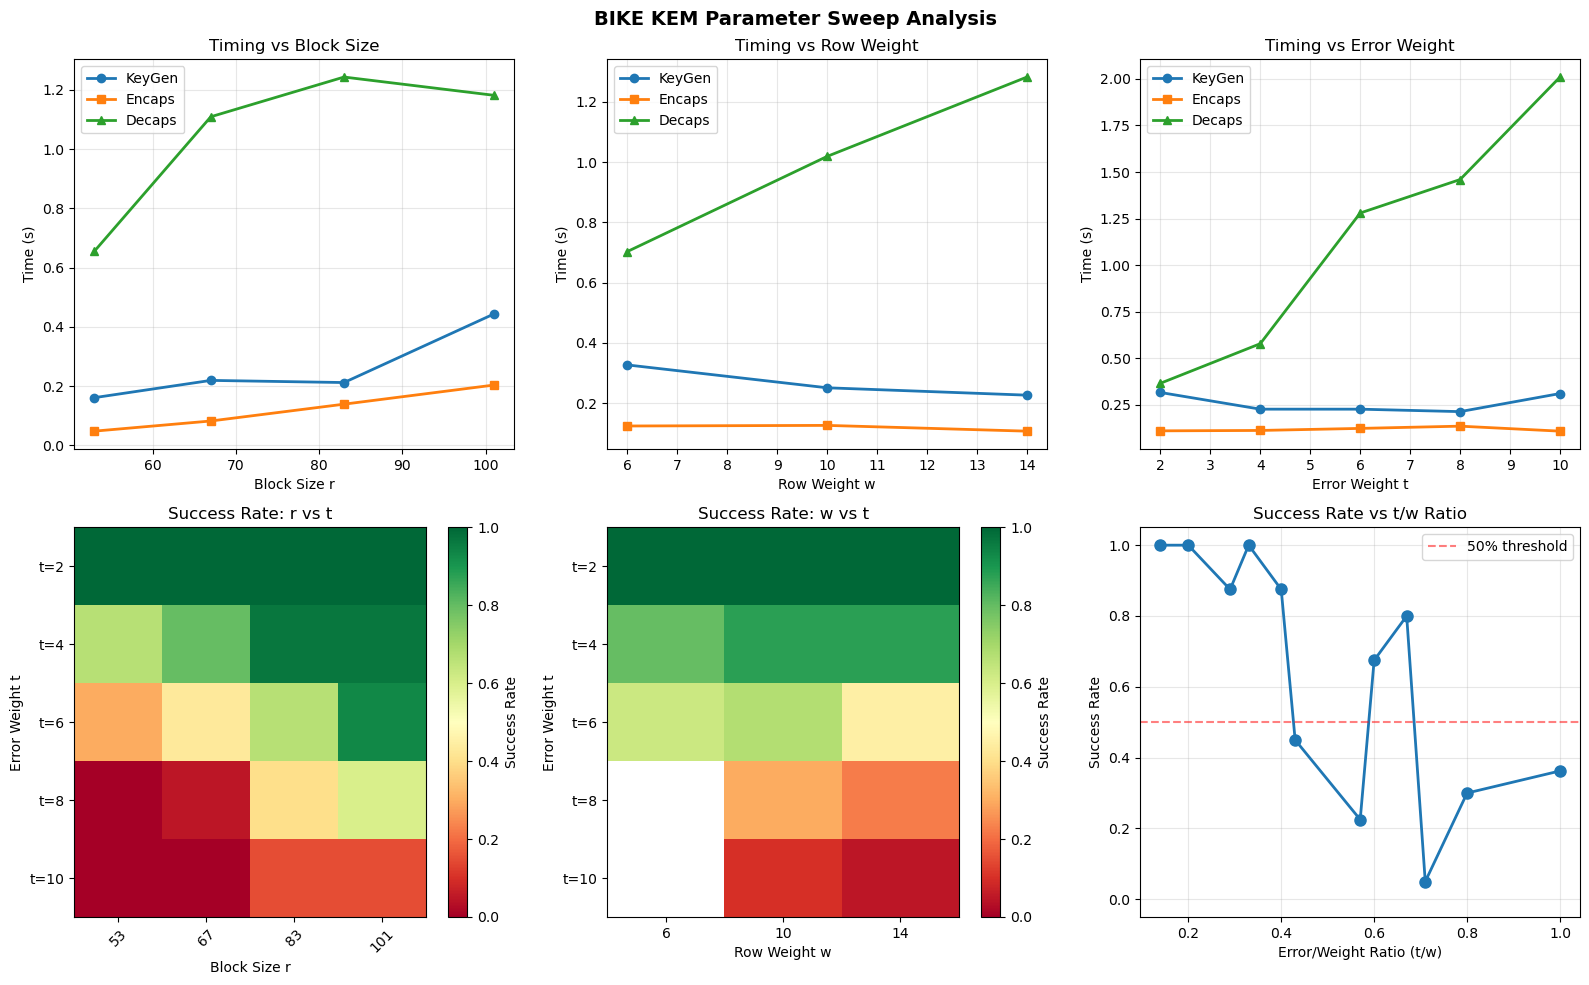


Summary Statistics

Success Rate by Block Size r:
      mean    std  count
r                       
53   0.454  0.425     26
67   0.523  0.431     26
83   0.692  0.345     26
101  0.785  0.329     26

Success Rate by Row Weight w:
     mean    std  count
w                      
6   0.808  0.254     24
10  0.590  0.402     40
14  0.520  0.441     40

Success Rate by Error Weight t:
     mean    std  count
t                      
2   1.000  0.000     24
4   0.850  0.198     24
6   0.583  0.343     24
8   0.262  0.290     16
10  0.075  0.124     16

⚠️  Configurations with <50% success rate:
  r  w  t  success_rate
 53  6  6           0.4
 53 10  8           0.0
 53 10  6           0.2
 53 10  6           0.4
 53 10 10           0.0
 53 14  8           0.0
 53 14  4           0.4
 53 14  6           0.0
 53 14 10           0.0
 67  6  6           0.4
 67  6  4           0.4
 67  6  6           0.2
 67 10 10           0.0
 67 10  8           0.2
 67 14  6           0.4
 67 14  8          

In [48]:
"""
BIKE KEM - Performance Analysis and Parameter Sweep
Parallel execution with tqdm progress tracking
"""

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from functools import partial


# ==============================================================================
# Worker Function for Parallel Execution
# ==============================================================================

def _run_single_bike_config(config, trials_per_key):
    """
    Worker function to run one BIKE configuration.
    
    Parameters:
        config: tuple of (r, w, t, key_idx)
        trials_per_key: number of encaps/decaps trials per key
    
    Returns:
        List of result dictionaries
    """
    # Convert all to Python native types
    r, w, t, key_idx = int(config[0]), int(config[1]), int(config[2]), int(config[3])
    trials_per_key = int(trials_per_key)
    
    results = []
    
    try:
        # Initialize BIKE with these parameters
        bike = BikeKEM(r=r, w=w, t=t)
        
        # Key generation timing
        start_kg = time.time()
        sk, pk = bike.key_gen()
        t_keygen = time.time() - start_kg
        
        # Run encaps/decaps trials
        t_enc_sum = 0.0
        t_dec_sum = 0.0
        successes = 0
        
        for trial in range(trials_per_key):
            # Encapsulation
            start_enc = time.time()
            c, (K_enc, (e0, e1)) = bike.encaps(pk)
            t_enc = time.time() - start_enc
            t_enc_sum += t_enc
            
            # Decapsulation
            start_dec = time.time()
            result = bike.decaps(sk, c)
            t_dec = time.time() - start_dec
            t_dec_sum += t_dec
            
            # Check success
            if result is not None and result[0] == K_enc:
                successes += 1
        
        avg_enc = float(t_enc_sum) / float(trials_per_key)
        avg_dec = float(t_dec_sum) / float(trials_per_key)
        success_rate = float(successes) / float(trials_per_key)
        
        results.append({
            'r': int(r),
            'w': int(w),
            't': int(t),
            'd': int(w // 2),
            'key_index': int(key_idx),
            'keygen_time': float(t_keygen),
            'encaps_time': float(avg_enc),
            'decaps_time': float(avg_dec),
            'success_rate': float(success_rate),
            'trials_per_key': int(trials_per_key),
            'status': 'success'
        })
        
    except Exception as e:
        # Record failed configurations
        results.append({
            'r': int(r),
            'w': int(w),
            't': int(t),
            'd': int(w // 2) if w else 0,
            'key_index': int(key_idx),
            'keygen_time': float('nan'),
            'encaps_time': float('nan'),
            'decaps_time': float('nan'),
            'success_rate': 0.0,
            'trials_per_key': int(trials_per_key),
            'status': f"error: {str(e)[:int(50)]}"
        })
    
    return results


# ==============================================================================
# Parameter Sweep Function
# ==============================================================================

def run_bike_parameter_sweep(
    r_values=None,
    w_values=None,
    t_values=None,
    keys_per_config=3,
    trials_per_key=10,
    n_jobs=4,
    seed=None
):
    """
    Run a comprehensive parameter sweep for BIKE KEM.
    
    Parameters:
        r_values: List of block sizes (primes). Default: [53, 67, 83, 101, 127]
        w_values: List of row weights (even, w/2 odd). Default: [6, 10, 14]
        t_values: List of error weights. Default: [2, 4, 6, 8]
        keys_per_config: Number of fresh key generations per parameter set
        trials_per_key: Number of encaps/decaps trials per key
        n_jobs: Number of parallel workers
        seed: Random seed for reproducibility
    
    Returns:
        List of result dictionaries
    """
    # Convert all inputs to Python native int
    keys_per_config = int(keys_per_config)
    trials_per_key = int(trials_per_key)
    n_jobs = int(n_jobs)
    if seed is not None:
        seed = int(seed)
    
    # Default parameter values - ensure all are Python int
    # r must be prime
    if r_values is None:
        r_values = [53, 67, 83, 101, 127, 151]
    # normalize regardless of source
    r_values = [int(r) for r in r_values]
    
    # w must be even and w/2 must be odd (per BIKE spec)
    if w_values is None:
        w_values = [6, 10, 14, 18]
    w_values = [int(w) for w in w_values]
    
    # t is error weight
    if t_values is None:
        t_values = [2, 4, 6, 8, 10]
    t_values = [int(t) for t in t_values]
    
    if seed is not None:
        import random
        random.seed(seed)
    
    print("\n" + "=" * 70)
    print("BIKE KEM - Parameter Sweep")
    print("=" * 70)
    print(f"\nParameters:")
    print(f"   r values (block size): {r_values}")
    print(f"   w values (row weight): {w_values}")
    print(f"   t values (error weight): {t_values}")
    print(f"   Keys per config: {keys_per_config}")
    print(f"   Trials per key: {trials_per_key}")
    print(f"   Parallel workers: {n_jobs}")
    
    # Generate all valid configurations
    configs = []
    for r in r_values:
        for w in w_values:
            for t in t_values:
                # Skip invalid configurations
                if w >= r:
                    continue
                if t >= r:
                    continue
                if t > w:
                    continue
                for key_idx in range(keys_per_config):
                    configs.append((int(r), int(w), int(t), int(key_idx)))
    
    total_configs = int(len(configs))
    print(f"\nTotal configurations to test: {total_configs}")
    print("-" * 70)
    
    results = []
    
    # Use ProcessPoolExecutor for parallel execution
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        # Submit all tasks
        future_to_config = {
            executor.submit(_run_single_bike_config, config, trials_per_key): config
            for config in configs
        }
        
        # Process with tqdm progress bar
        with tqdm(total=total_configs, desc="Parameter Sweep", unit="config") as pbar:
            for future in as_completed(future_to_config):
                config = future_to_config[future]
                try:
                    config_results = future.result()
                    results.extend(config_results)
                except Exception as e:
                    r, w, t, key_idx = int(config[0]), int(config[1]), int(config[2]), int(config[3])
                    results.append({
                        'r': r,
                        'w': w,
                        't': t,
                        'd': w // 2,
                        'key_index': key_idx,
                        'keygen_time': float('nan'),
                        'encaps_time': float('nan'),
                        'decaps_time': float('nan'),
                        'success_rate': 0.0,
                        'trials_per_key': trials_per_key,
                        'status': f"executor error: {str(e)[:int(30)]}"
                    })
                pbar.update(int(1))
    
    print(f"\nCompleted {len(results)} configurations")
    return results


# ==============================================================================
# Visualization Functions
# ==============================================================================

def save_and_plot_bike_sweep(results, csv_name="bike_param_sweep_results.csv"):
    """
    Save results to CSV and generate visualizations.
    """
    df = pd.DataFrame(results)
    df.to_csv(csv_name, index=False)
    print(f"\nResults saved to {csv_name}")
    
    # Filter successful runs for timing analysis
    df_success = df[df['status'] == 'success'].copy()
    
    if len(df_success) == 0:
        print("No successful runs to plot!")
        return df
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # --- Plot 1: Timing vs Block Size r ---
    ax1 = axes[0, 0]
    agg_r = df_success.groupby('r', as_index=False).agg({
        'keygen_time': 'mean',
        'encaps_time': 'mean',
        'decaps_time': 'mean'
    })
    ax1.plot(agg_r['r'], agg_r['keygen_time'], 'o-', label='KeyGen', linewidth=2)
    ax1.plot(agg_r['r'], agg_r['encaps_time'], 's-', label='Encaps', linewidth=2)
    ax1.plot(agg_r['r'], agg_r['decaps_time'], '^-', label='Decaps', linewidth=2)
    ax1.set_xlabel('Block Size r')
    ax1.set_ylabel('Time (s)')
    ax1.set_title('Timing vs Block Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # --- Plot 2: Timing vs Row Weight w ---
    ax2 = axes[0, 1]
    agg_w = df_success.groupby('w', as_index=False).agg({
        'keygen_time': 'mean',
        'encaps_time': 'mean',
        'decaps_time': 'mean'
    })
    ax2.plot(agg_w['w'], agg_w['keygen_time'], 'o-', label='KeyGen', linewidth=2)
    ax2.plot(agg_w['w'], agg_w['encaps_time'], 's-', label='Encaps', linewidth=2)
    ax2.plot(agg_w['w'], agg_w['decaps_time'], '^-', label='Decaps', linewidth=2)
    ax2.set_xlabel('Row Weight w')
    ax2.set_ylabel('Time (s)')
    ax2.set_title('Timing vs Row Weight')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # --- Plot 3: Timing vs Error Weight t ---
    ax3 = axes[0, 2]
    agg_t = df_success.groupby('t', as_index=False).agg({
        'keygen_time': 'mean',
        'encaps_time': 'mean',
        'decaps_time': 'mean'
    })
    ax3.plot(agg_t['t'], agg_t['keygen_time'], 'o-', label='KeyGen', linewidth=2)
    ax3.plot(agg_t['t'], agg_t['encaps_time'], 's-', label='Encaps', linewidth=2)
    ax3.plot(agg_t['t'], agg_t['decaps_time'], '^-', label='Decaps', linewidth=2)
    ax3.set_xlabel('Error Weight t')
    ax3.set_ylabel('Time (s)')
    ax3.set_title('Timing vs Error Weight')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # --- Plot 4: Success Rate Heatmap (r vs t) ---
    ax4 = axes[1, 0]
    pivot_rt = df_success.pivot_table(
        values='success_rate',
        index='t',
        columns='r',
        aggfunc='mean'
    )
    im4 = ax4.imshow(pivot_rt, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    ax4.set_yticks(range(len(pivot_rt.index)))
    ax4.set_yticklabels([f't={int(t)}' for t in pivot_rt.index])
    ax4.set_xticks(range(len(pivot_rt.columns)))
    ax4.set_xticklabels([int(r) for r in pivot_rt.columns], rotation=45)
    ax4.set_xlabel('Block Size r')
    ax4.set_ylabel('Error Weight t')
    ax4.set_title('Success Rate: r vs t')
    plt.colorbar(im4, ax=ax4, label='Success Rate')
    
    # --- Plot 5: Success Rate Heatmap (w vs t) ---
    ax5 = axes[1, 1]
    pivot_wt = df_success.pivot_table(
        values='success_rate',
        index='t',
        columns='w',
        aggfunc='mean'
    )
    im5 = ax5.imshow(pivot_wt, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    ax5.set_yticks(range(len(pivot_wt.index)))
    ax5.set_yticklabels([f't={int(t)}' for t in pivot_wt.index])
    ax5.set_xticks(range(len(pivot_wt.columns)))
    ax5.set_xticklabels([int(w) for w in pivot_wt.columns])
    ax5.set_xlabel('Row Weight w')
    ax5.set_ylabel('Error Weight t')
    ax5.set_title('Success Rate: w vs t')
    plt.colorbar(im5, ax=ax5, label='Success Rate')
    
    # --- Plot 6: Success Rate vs t/w Ratio ---
    ax6 = axes[1, 2]
    df_success['t_w_ratio'] = df_success['t'].astype(float) / df_success['w'].astype(float)
    df_success['t_w_ratio_rounded'] = df_success['t_w_ratio'].round(2)
    agg_ratio = df_success.groupby('t_w_ratio_rounded', as_index=False).agg({
        'success_rate': 'mean'
    })
    ax6.plot(agg_ratio['t_w_ratio_rounded'], agg_ratio['success_rate'], 'o-', linewidth=2, markersize=8)
    ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% threshold')
    ax6.set_xlabel('Error/Weight Ratio (t/w)')
    ax6.set_ylabel('Success Rate')
    ax6.set_title('Success Rate vs t/w Ratio')
    ax6.set_ylim(-0.05, 1.05)
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('BIKE KEM Parameter Sweep Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('bike_param_sweep_plots.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 70)
    print("Summary Statistics")
    print("=" * 70)
    
    print("\nSuccess Rate by Block Size r:")
    print(df_success.groupby('r')['success_rate'].agg(['mean', 'std', 'count']).round(int(3)))
    
    print("\nSuccess Rate by Row Weight w:")
    print(df_success.groupby('w')['success_rate'].agg(['mean', 'std', 'count']).round(int(3)))
    
    print("\nSuccess Rate by Error Weight t:")
    print(df_success.groupby('t')['success_rate'].agg(['mean', 'std', 'count']).round(int(3)))
    
    # Identify failure boundaries
    low_success = df_success[df_success['success_rate'] < 0.5]
    if len(low_success) > 0:
        print("\n⚠️  Configurations with <50% success rate:")
        print(low_success[['r', 'w', 't', 'success_rate']].drop_duplicates().to_string(index=False))
    
    return df


# ==============================================================================
# Run the Parameter Sweep
# ==============================================================================

# Run with default parameters (adjust as needed)
print("Starting BIKE KEM Parameter Sweep...")
print("This may take several minutes depending on your system.\n")

sweep_results = run_bike_parameter_sweep(
    r_values=[53, 67, 83, 101],      # Prime block sizes
    w_values=[6, 10, 14],             # Row weights (even, w/2 odd)
    t_values=[2, 4, 6, 8, 10],        # Error weights
    keys_per_config=2,
    trials_per_key=5,
    n_jobs=10,
    seed=42
)

# Save and visualize results
df_results = save_and_plot_bike_sweep(sweep_results, csv_name="bike_param_sweep_results.csv")